In [126]:
import sys, os
from pathlib import Path

# find repo root (parent of "experiments") and add to sys.path
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path(os.getcwd()).parents[0]
sys.path.insert(0, str(repo_root))

from eap_fit_hh.inference import EKFTrainer
from eap_fit_hh.utils import compute_comp_xyz, distance, plot_cond_params, compute_eap, build_axial_matrix, build_eap_M, get_surface_areas

In [127]:
import jaxley as jx
from jaxley.channels import Na, K, Leak, Km, CaL
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
tf = tfp.tf2jax
tfd = tfp.distributions

In [128]:
ncomps = 4
comp = jx.Compartment()
true_branch = jx.Branch(comp, ncomp=ncomps)

true_branch.set("radius",2.0)
true_branch.set("length",24.0) 

true_branch.insert(Na())
true_branch.insert(K())
true_branch.insert(Leak())
true_branch.insert(Km())
true_branch.insert(CaL())


true_branch.init_states()

cell_positions = compute_comp_xyz(true_branch)

In [129]:
# n_points = 10
# first_x = cell_positions[0,0]
# last_x = cell_positions[-1,0]
# len_cell = last_x - first_x
# x = jnp.linspace(first_x, last_x, n_points)
# y = jnp.array([0.]) #all sites spaced by 6 um
# z = jnp.array([10.])
# grid = jnp.dstack(jnp.meshgrid(x, y, z)).reshape((n_points, 3))

first_x = cell_positions[0,0]
last_x = cell_positions[-1,0]
len_cell = last_x - first_x
mid_cell = first_x + len_cell/2

n_points_per_col = 5
n_points = 2*n_points_per_col
l = 6
x = jnp.linspace(mid_cell-6*(n_points_per_col-1)/2, mid_cell+6*(n_points_per_col-1)/2, n_points_per_col)
y = jnp.array([-l/2,l/2]) #all sites spaced by 6 um
z = jnp.array([10.])
grid = jnp.dstack(jnp.meshgrid(x, y, z)).reshape((n_points, 3))

distances = distance(grid, cell_positions) # in um
distances_CM = distances * 10**(-4)

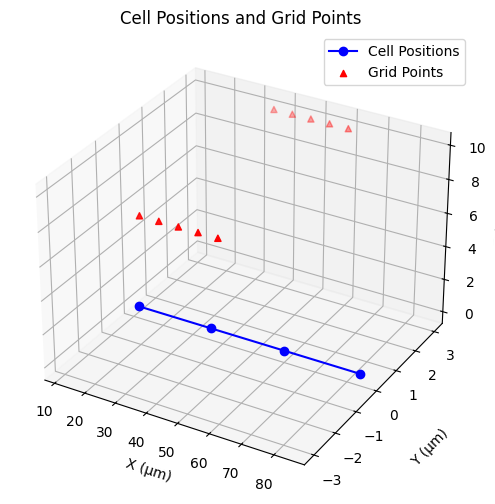

In [130]:
# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot compartments with lines
ax.plot(cell_positions[:, 0], cell_positions[:, 1], cell_positions[:, 2], 'b-o', label='Cell Positions')

# Plot grid points
ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2], c='r', marker='^', label='Grid Points')

# Labels and legend
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)", labelpad=15)
ax.set_zlabel("Z (μm)")
ax.set_title("Cell Positions and Grid Points")
ax.legend()

In [131]:
dt = 0.025  # ms
t_max = 20.0
time = jnp.arange(0, t_max+2*dt, dt)
n_timesteps = len(time)
current = jx.step_current(i_delay=1.0, i_dur=20., i_amp=0.17, delta_t=dt, t_max=t_max)#0.02
true_branch.comp(0).stimulate(current)

true_branch.comp("all").record("v")

true_outputs = jx.integrate(true_branch)

Added 1 external_states. See `.externals` for details.
Added 4 recordings. See `.recordings` for details.


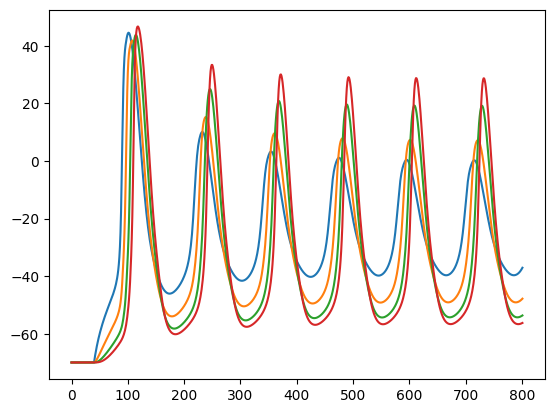

In [132]:
for i in range(ncomps):
    plt.plot(true_outputs[i,:])

In [133]:
A = build_axial_matrix(true_branch)
padded_current = jnp.concatenate([jnp.array([0.]),current])
M = build_eap_M(A, distances_CM, 1000)
v = true_outputs[:ncomps]
emissions_EAP = compute_eap(v, M, padded_current, 0, distances_CM, 1000) + tfd.Normal(0,0.0001).sample((n_points, n_timesteps), seed=random.PRNGKey(0))

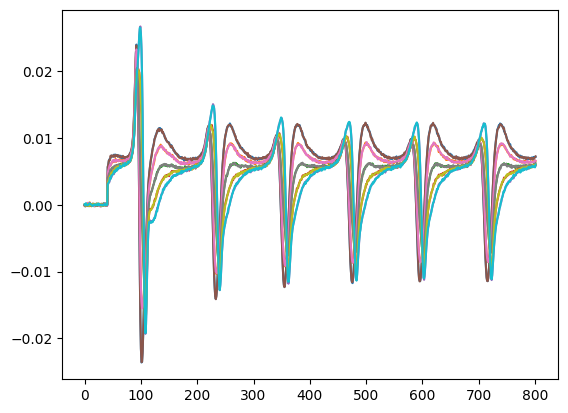

In [134]:
for i in range(len(emissions_EAP)):
    plt.plot(emissions_EAP[i])

In [135]:
ncomps = 4
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=ncomps)

branch.set("radius",2.0)
branch.set("length",24.0) 

branch.insert(Na())
branch.insert(K())
branch.insert(Leak())

branch.init_states()

In [136]:
branch.comp(0).stimulate(current)

branch.comp("all").record("v")

Added 1 external_states. See `.externals` for details.
Added 4 recordings. See `.recordings` for details.


In [137]:
HH_params = ['Na_gNa', 'K_gK', 'Leak_gLeak']
dynamics_std = {'Na_n': 0.00001, 'Na_m': 0.00001, 'K_h': 0.00001, 'i_HH': 0.01}

In [138]:
Trainer = EKFTrainer(cell = branch,
                     trainable_params = HH_params,
                     dt = dt,
                     grid = grid,
                     extracellular_resistivity = 1000)

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
['Na_gNa', 'K_gK', 'Leak_gLeak']
['Na_gNa', 'K_gK', 'Leak_gLeak']


In [139]:
true_cond = {'Na_gNa': 0.01, 'K_gK': 0.005, 'Leak_gLeak': 0.0001}
true_jaxley_cond = Trainer._to_jaxley_params(true_cond)

In [140]:
init_std = {'v': 1.}

In [141]:
out = Trainer.train(data = (emissions_EAP.T, current),
            init_cond_params = true_jaxley_cond,
            init_noise_params = init_std,
            lr = 0.5,
            num_epochs = 1000,
            output = ['last post means', "last post covariances", "mll"],
            smoother = True,
            obs_std = 0.0001
            )

EKF train: 100%|████████████████████████████| 1000/1000 [03:06<00:00,  5.36it/s]


In [142]:
post_v = out["last post means"]['v']
post_var = out["last post covariances"]

In [143]:
post_var.shape

(802, 28, 28)

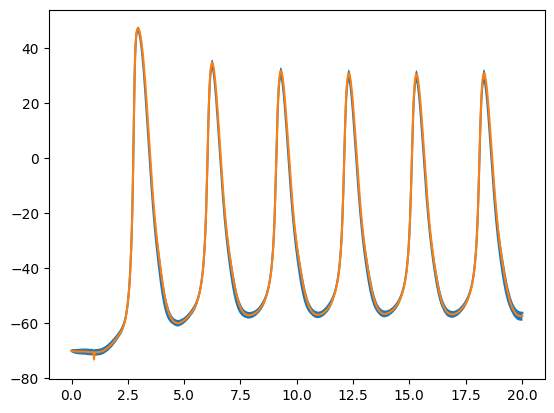

In [147]:
comp = 3
v_post_var = post_var[:,comp,comp]
std = jnp.sqrt(v_post_var)
mu = post_v[:,comp]
plt.plot(time,true_outputs[comp])
plt.plot(time,mu)
plt.fill_between(time, mu - 2*std, mu + 2*std, label="±2σ")

## Adam

In [148]:
import pickle
with open("misp_miss.pkl", "rb") as f: #40 (idx=1)
    data = pickle.load(f)
    params_mse = data["params"]
    loss_mse = data["loss"]

In [149]:
idx_flat = jnp.argmin(loss_mse)                           # scalar flat index
i, j = jnp.unravel_index(idx_flat, loss_mse.shape)        # 2D indices
best_loss_mse = loss_mse[i, j]

In [150]:
from jax.tree_util import tree_map
best_param_mse = tree_map(lambda x: x[i,j],params_mse)

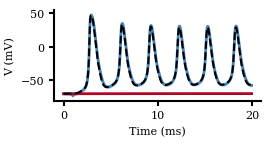

In [155]:
import matplotlib as mpl

t_max = 20.
time_ms = jnp.arange(0, t_max-dt, dt)
comp = 3
colors = plt.cm.coolwarm(jnp.linspace(0, 1, 2))
MSE_volt = []
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5/2, 1.5))
    post_v_comp = post_v[1:-2,comp]
    v_post_std_comp = jnp.sqrt(post_var[1:-2,comp,comp])
    upper_bound = post_v_comp + 2*v_post_std_comp
    lower_bound = post_v_comp - 2*v_post_std_comp
    ax.plot(time_ms, post_v_comp, color="steelblue", linewidth=2)
    ax.fill_between(time_ms, lower_bound, upper_bound, color="steelblue", alpha=0.2)

    inferred_outputs = jx.integrate(branch, params=best_param_mse)
    inferred_v = inferred_outputs[comp]
    ax.plot(time_ms, inferred_v[1:-2], color=colors[1], linewidth=2)

    plt.plot(time_ms,true_outputs[comp,1:-2].T,linestyle="--", color="black")
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('V (mV)')

    fig.tight_layout()
    plt.savefig("sampled_params_last_comp_misp_missing.svg")